# Computing impacts with various explainers

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../..")
import timexplain as tx
import experiments.base as ex

## Load the UCR FaceFour dataset

In [2]:
X_train, y_train, X_test, y_test = ex.dataset("ucr", "FaceFour")
size_x = X_train.shape[1]

## Select a time series from the test set as specimen

In [3]:
specimen_idx = 1
x_specimen = X_test[specimen_idx]
y_specimen = y_test[specimen_idx]

## Fit various models and check their prediction of the specimen

In [4]:
print("True class:", y_specimen)

True class: 1


In [5]:
st = ex.classifiers.ShapeletTransformClassifier(time_contract_in_mins=0.5)
st.fit(X_train, y_train)
print("ST prediction:", st.predict(x_specimen[np.newaxis])[0])

ST prediction: 1


In [6]:
sax_vsm = ex.classifiers.SAXVSMEnsembleClassifier(n_bins=[6, 8, 12, 16, 20], window_size=[6, 8, 12, 16, 20], strategy=["uniform"])
sax_vsm.fit(X_train, y_train)
print("SAX-VSM prediction:", sax_vsm.predict(x_specimen[np.newaxis])[0])

SAX-VSM prediction: 1


In [7]:
weasel = ex.classifiers.WEASELEnsembleClassifier(window_sizes=np.arange(0.05, 1.05, 0.05), word_size=[2, 4, 6], norm_mean=[True, False])
weasel.fit(X_train, y_train)
print("WEASEL prediction:", weasel.predict(x_specimen[np.newaxis])[0])

WEASEL prediction: 1


In [8]:
rotf = ex.classifiers.RotationForestClassifier()
rotf.fit(X_train, y_train)
print("RotF prediction:", rotf.predict(x_specimen[np.newaxis])[0])

RotF prediction: 1


In [9]:
resnet = ex.classifiers.Resnet()
resnet.fit(X_train, y_train, epochs=50)
print("ResNet prediction:", resnet.predict(x_specimen[np.newaxis])[0])

ResNet prediction: 1


## Explain the predictions of the specimen using *model-agnostic* explainers

First, explain *ST*, *SAX-VSM*, *RotF*, and *ResNet* using model-agnostic *timeXplain* equipped with the time slice mapping with sample replacement. In addition to sample replacement (which is the default), all other replacements mentioned in the paper are available in the `tx.om` module.

In [10]:
time_om = tx.om.TimeSliceOmitter(size_x, time_slicing=30, x_repl=tx.om.x_sample)

In [11]:
st_expl_agnostic      = tx.om.KernelShapExplainer(time_om, st.predict_proba, X_bg=X_test, y_bg=y_test,
                                                  n_samples=500, n_builds=5, bgcs=True).explain(x_specimen)

In [12]:
sax_vsm_expl_agnostic = tx.om.KernelShapExplainer(time_om, sax_vsm.predict_proba, X_bg=X_test, y_bg=y_test,
                                                  n_samples=500, n_builds=5, bgcs=True).explain(x_specimen)

In [13]:
rotf_expl_agnostic    = tx.om.KernelShapExplainer(time_om, rotf.predict_proba, X_bg=X_test, y_bg=y_test,
                                                  n_samples=500, n_builds=5, bgcs=True).explain(x_specimen)

In [14]:
resnet_expl_agnostic  = tx.om.KernelShapExplainer(time_om, resnet.predict_proba, X_bg=X_test, y_bg=y_test,
                                                  n_samples=500, n_builds=5, bgcs=True).explain(x_specimen)

Next, explain *WEASEL* using model-agnostic *timeXplain* equipped witht the frequency band mapping with the patch strategy.
Alternatively, one may use the filter strategy, which is available as `tx.om.FreqDiceFilterOmitter`.

In [15]:
freq_om = tx.om.FreqDicePatchOmitter(size_x, time_slicing=15, freq_slicing=5)

In [16]:
weasel_expl_agnostic  = tx.om.KernelShapExplainer(freq_om, weasel.predict_proba, X_bg=X_test, y_bg=y_test,
                                                 n_samples=500, n_builds=5, bgcs=True).explain(x_specimen)

Note that we do not demonstrate the statistic mapping here because all of our UCR demo data sets are z-normalized to mean 0 and standard deviation 1. Hence, the statistics of a time series are not used by any model, causing all statistic impacts to always be 0. You can try this out with *timeXplain* and verify it.

## Explain the predictions of the specimen using *model-specific* explainers

Now, we explain all classifiers with model-specific approaches. Concretely, *ST* ist explained via *shapelet superposition*, *SAX-VSM* via *SAX window superposition* (in the time domain), *WEASEL* via *SFA window superposition* (in the frequency domain), *RotF* via *TreeSHAP*, and *ResNet* via *class activation maps*. Superposition is implemented by the `>>` operator. For the superposition methods, we do not employ *divide_spread* because that would produce more technically faithful, yet less human-interpretable impacts.

In [17]:
st_expl_specific      = (tx.spec.ShapeletTransformExplainer(st["st"]) >> tx.spec.TreeShapExplainer(st["rf"])) \
                            .explain(st["transform"].transform(x_specimen[np.newaxis]))[0]

In [18]:
sax_vsm_expl_specific = tx.MeanExplainer([tx.spec.SaxVsmWordSuperposExplainer(sub["sax_vsm"])
                                          for sub in sax_vsm.estimators_]) \
                            .explain(x_specimen)

In [19]:
weasel_expl_specific  = tx.MeanExplainer([tx.spec.WeaselExplainer(sub["weasel"], domain="freq") >>
                                          tx.spec.LinearShapExplainer(sub["logreg"], X_bg=sub["weasel"].transform(X_test))
                                          for sub in weasel.estimators_]) \
                            .explain(x_specimen)

In [20]:
rotf_expl_specific    = tx.spec.TreeShapExplainer(rotf, X_bg=X_test) \
                            .explain(x_specimen)

In [21]:
resnet_expl_specific  = tx.spec.NeuralCamExplainer(resnet.estimator) \
                            .explain(resnet.prepare_X(x_specimen[np.newaxis]))[0]

## Plot the impacts towards the true class of the specimen

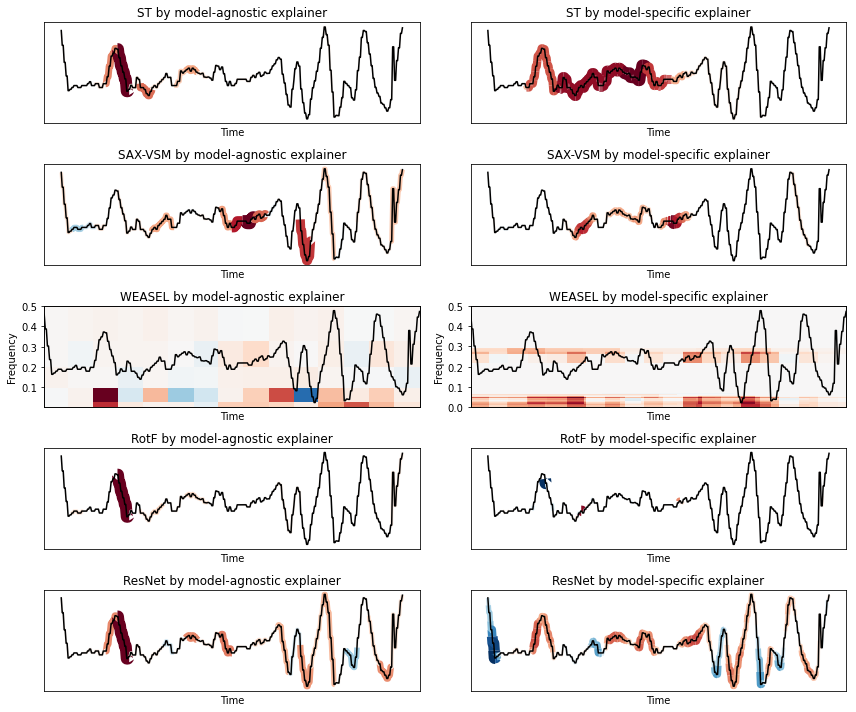

In [22]:
fig, axs = plt.subplots(5, 2, figsize=(12, 10))

def plot1d(ax, expl, title):
    ax.set_title(title)
    tx.plot.saliency1d(expl, ax=ax, model_output=y_specimen - 1, slice_edge_style=None, legend_style=None, impact_legend=None)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

def plot2d(ax, expl, title):
    ax.set_title(title)
    tx.plot.saliency2d(expl, ax=ax, model_output=y_specimen - 1, dice_edge_style=None, legend_style=None, impact_legend=None)
    ax.xaxis.set_ticks([])

plot1d(axs[0, 0], st_expl_agnostic, "ST by model-agnostic explainer")
plot1d(axs[0, 1], st_expl_specific, "ST by model-specific explainer")

plot1d(axs[1, 0], sax_vsm_expl_agnostic, "SAX-VSM by model-agnostic explainer")
plot1d(axs[1, 1], sax_vsm_expl_specific, "SAX-VSM by model-specific explainer")

plot2d(axs[2, 0], weasel_expl_agnostic, "WEASEL by model-agnostic explainer")
plot2d(axs[2, 1], weasel_expl_specific, "WEASEL by model-specific explainer")

plot1d(axs[3, 0], rotf_expl_agnostic, "RotF by model-agnostic explainer")
plot1d(axs[3, 1], rotf_expl_specific, "RotF by model-specific explainer")

plot1d(axs[4, 0], resnet_expl_agnostic, "ResNet by model-agnostic explainer")
plot1d(axs[4, 1], resnet_expl_specific, "ResNet by model-specific explainer")

fig.tight_layout()